In [69]:
import os
import struct
from array import array as pyarray
from numpy import append, array, float_, zeros

import tensorflow as tf
import numpy as np

# 1 Data preprocessing

# 1. Get data and visualize the data

In [72]:
def load_mnist(dataset = "training", digits=np.arange(10), path = "data"):
    """
    Loads MNIST files into 3D numpy arrays
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    """
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()
        
    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows * cols), dtype=float_)
    labels = zeros((N, 10), dtype=float_)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows * cols))
        labels[i,lbl[ind[i]]] = 1.0

    return images, labels

In [91]:
# load MNIST data
X_train, Y_train = load_mnist(dataset="training")
X_test, Y_test = load_mnist(dataset="testing")

In [83]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


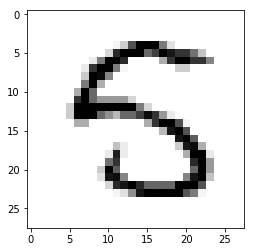

In [90]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import random

rand = np.random.randint(len(X_train))
plt.imshow(X_train[rand].reshape((28,28)), cmap=cm.gray_r)
plt.show()

# 3. Training data

In [96]:
mnist_width = 28
n_visible = np.power(mnist_width, 2)
n_hidden = 500
corruption_level = 0.3

In [25]:
def model(X, mask, W, b, W_prime, b_prime):
    # X filter
    X_tile = mask * X
    Y = tf.nn.sigmoid(tf.matmul(X_tile, W) + b)
    Z = tf.nn.sigmoid(tf.matmul(Y, W_prime) + b_prime)
    
    return Z

In [26]:
X = tf.placeholder("float32", [None, n_visible], name="X_input")
mask = tf.placeholder("float32", [None, n_visible], name="mask")
W_init_peak = 4 * np.sqrt(6. / (n_visible + n_hidden))
W_init = tf.random_uniform(shape=[n_visible, n_hidden], minval=-W_init_peak, maxval=W_init_peak)
W = tf.Variable(W_init, name="W")
b = tf.Variable(tf.zeros([n_hidden]), name="b")

W_prime = tf.transpose(W, name="W_prime")
b_prime = tf.Variable(tf.zeros([n_visible], name="b_prime"))

Z = model(X, mask, W, b, W_prime, b_prime)

# MSE
cost = tf.reduce_sum(tf.pow(X - Z, 2))
train_op = tf.train.GradientDescentOptimizer(0.02).minimize(cost)

In [101]:
# Launch the graph in a session
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for i in range(10):
        for start, end in zip(range(0, len(X_train), 128), range(128, len(X_train), 128)):
            input_ = X_train[start:end]
            mask_np = np.random.binomial(1, 1 - corruption_level, input_.shape)
            sess.run(train_op, feed_dict={X: input_, mask: mask_np})

        mask_np = np.random.binomial(1, 1 - corruption_level, X_test.shape)
        print(i, sess.run(cost, feed_dict={X: X_test, mask: mask_np}))

0 57565630000.0
1 57565626000.0
2 57565620000.0
3 57565620000.0
4 57565620000.0
5 57565614000.0
6 57565630000.0
7 57565635000.0
8 57565626000.0
9 57565667000.0
